In [5]:
%load_ext autoreload
%cd /workdir/ComfyUI/
%autoreload 2
    
from comfywr.csd_lib import load_image, cn_preprocess, control_net_set_create, \
    control_net_set_apply_hint, init_extra_nodes, load_sd_checkpoint, load_cn, load_upscale_model, load_lora, \
    load_clip_vision, load_ipadapter, run_marigold_depth_estimation, image_scale, ultimate_sd_upscale, clip_encode, \
    ip_adapter_apply, load_depth_anything_v2, run_depth_anything_v2, image_scale_by

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/workdir/ComfyUI


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
import importlib
# Mesh = importlib.import_module('custom_nodes.ComfyUI-3D-Pack.mesh_processer.mesh').Mesh

In [7]:
mesh_path = '/workdir/ComfyUI/output/Unique3d_v2.1/initial2.obj'
# mesh = Mesh.load(mesh_path)

In [8]:
# import torch
# import numpy as np
import matplotlib.pyplot as plt 
# pt = mesh.convert_to_pointcloud()
# IMG_RES = 1024
# img = np.zeros((1024, 1024), dtype=np.float32)
# points = ((pt.points + 0.5) * (IMG_RES - 1)).astype(int)
# points.shape
# # points = points[:1000]
# views = []
# 
# xs, ys = points[:, [0, 1]].T
# v = img.copy()
# v[IMG_RES - 1 - ys, xs] = 1
# views.append(v)
# 
# zs, ys = points[:, [2, 1]].T
# v = img.copy()
# v[IMG_RES - 1 - ys, zs] = 1
# views.append(v)
# 
# plt.figure(figsize=(20,20))
# plt.imshow(np.concatenate(views, axis=1) * 255)
# plt.show()

In [9]:
!pip install "pyglet<2"


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


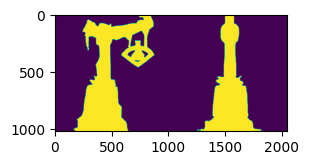

In [10]:
import numpy as np
import trimesh
from PIL import Image, ImageDraw

from custom_nodes.comfywr_nodes.nodes import mesh_silhouette_images

mesh = trimesh.load(mesh_path)
original_mesh_silh = mesh_silhouette_images(mesh)
plt.figure(figsize=(3,3))
plt.imshow(np.concatenate(original_mesh_silh, 1))
plt.show()

(1024, 1024)


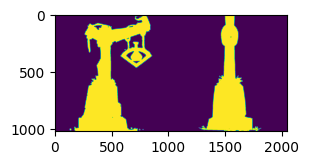

In [11]:
import cv2
target_silh = [
    cv2.imread('/workdir/ComfyUI/output/Unique3d_v2.1/silhouette_00073_.png')[:, :, 0],
    cv2.imread('/workdir/ComfyUI/output/Unique3d_v2.1/silhouette_00074_.png')[:, :, 0],
]
for i in range(2):
    target_silh[i] = cv2.resize(target_silh[i], (1024, 1024)) > 0
    
print(target_silh[0].shape)
plt.figure(figsize=(3,3))
plt.imshow(np.concatenate(target_silh, 1))
plt.show()

[0.94598644 0.02674643 0.02992758] [0.9671977  0.01269536 0.02552786]


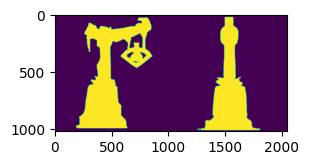

In [12]:
from custom_nodes.comfywr_nodes.nodes import align_images
aligned1, params1 = align_images(original_mesh_silh[0].astype(np.uint8) * 255,
                                target_silh[0].astype(np.uint8) * 255)
aligned2, params2 = align_images(original_mesh_silh[1].astype(np.uint8) * 255,
                                target_silh[1].astype(np.uint8) * 255)
print(params1.x, params2.x)
plt.figure(figsize=(3,3))
aligned_silh = [aligned1 > 0, aligned2 > 0]
plt.imshow(np.concatenate(aligned_silh, 1))
plt.show()

In [27]:
# scale = (params1.x[0] + params2.x[0]) / 2
scale = params1.x[0]
offset_x = params1.x[1]
# offset_y = (params1.x[2] + params2.x[2]) / 2
offset_y = params1.x[2]
# offset_z = params2.x[1]
offset_z = 100

In [32]:
from custom_nodes.comfywr_nodes.nodes import transform_mesh
import trimesh
aligned_mesh = trimesh.load(mesh_path)
# aligned_mesh = transform_mesh(aligned_mesh.copy(), offset_y, offset_x, offset_z, *[scale] * 3)
aligned_mesh = transform_mesh(aligned_mesh, 0, 0, 0, *[scale] * 3)
# aligned_mesh = transform_mesh(aligned_mesh, 0, 0, 0, *[1] * 3)
aligned_mesh_slih = mesh_silhouette_images(aligned_mesh)

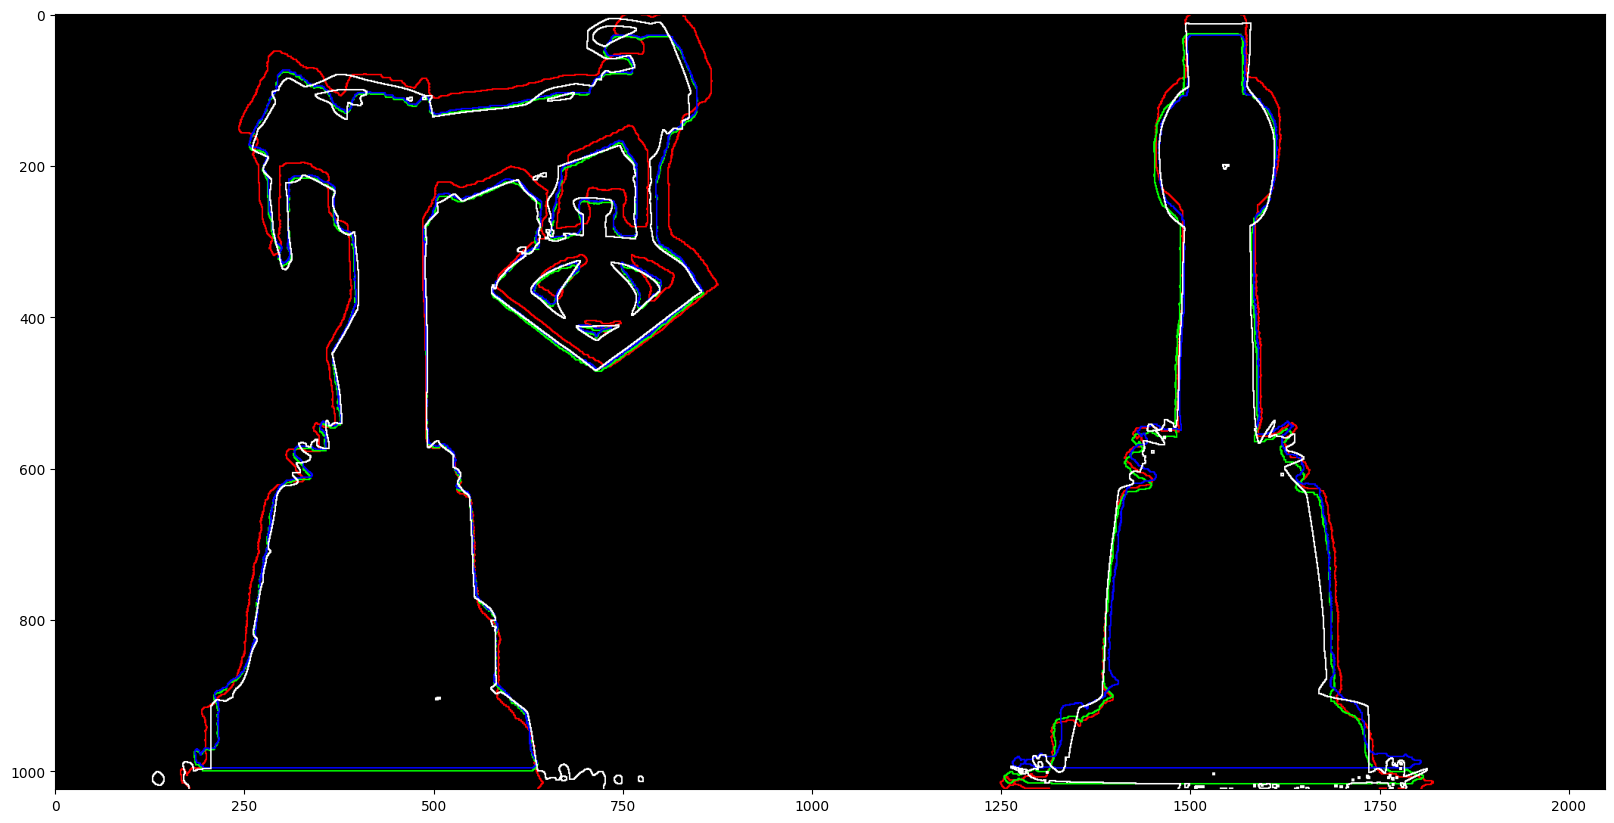

In [33]:
def visualize(silhouettes):
    vis = np.zeros((silhouettes[0][0].shape[0], silhouettes[1][1].shape[1] * 2, 3), dtype=np.uint8)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255)]
    for s, col in zip(silhouettes, colors):
        assert 0 < np.mean(s) < 1
        mask = np.concatenate(s, 1).astype(np.uint8) * 255
        assert mask.shape == vis.shape[:2]
        edges = cv2.dilate(mask, np.ones((3, 3))) - cv2.erode(mask, np.ones((3, 3)))
        vis[edges > 0] = col
    plt.figure(figsize=(20,20))
    plt.imshow(vis)
    plt.show()

visualize([original_mesh_silh, aligned_silh, aligned_mesh_slih, target_silh])
# visualize([*[aligned_silh]*2, *[aligned_mesh_slih]*2])